In [124]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import neighbors

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

** Load datasets **

In [125]:
# load datasets
train_df = pd.read_csv('./../datasets/train.csv', error_bad_lines=False)
test_df = pd.read_csv('./../datasets/test.csv', error_bad_lines=False)
unlabeled_df = pd.read_csv('./../datasets/unlabeled.csv', error_bad_lines=False)

In [126]:
print(train_df.shape)
print(test_df.shape)
print(unlabeled_df.shape)

(1047, 3)
(404, 3)
(8574, 3)


## Data preparation

The data are already cleaned and now ready to use.

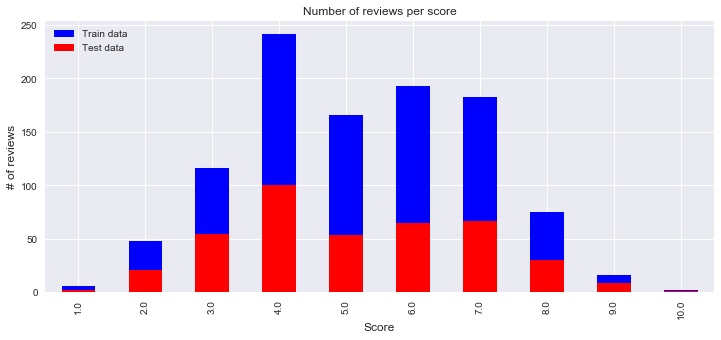

In [127]:
# Check the distribution of samples over labels
df_stats_train = train_df.score.value_counts()
df_stats_test = test_df.score.value_counts()

plt.figure(figsize=(12,5))
plt.title('Number of reviews per score')
ax1 = df_stats_train.sort_index(ascending=True).plot(color='blue', grid=True, label='Train data', kind='bar', legend=False)
ax2 = df_stats_test.sort_index(ascending=True).plot(color='red', grid=True, label='Test data', kind='bar', legend=False)
ax1.legend(loc=1)
ax2.legend(loc=2)
plt.ylabel('# of reviews', fontsize=12)
plt.xlabel('Score', fontsize=12)
plt.show()

In [128]:
# Check label values
print('Train labels values: ', train_df.score.unique())
print('Test labels values: ', test_df.score.unique())

Train labels values:  [ 4.  3.  5.  2.  1.  7.  8.  6.  9. 10.]
Test labels values:  [ 5.  4.  3.  2.  1.  8.  6.  7.  9. 10.]


In [129]:
# Cast score column to int
train_df['score'] = train_df.score.astype(int)
test_df['score'] = test_df.score.astype(int)

print(train_df.head())
print(test_df.head())

  review_file_id                                           comments  score
0       729.json  strengths the authors propose a kernel based m...      4
1       338.json  strengths the related work is quite thorough a...      4
2       343.json  strengths i well organized and easy to underst...      3
3       752.json  strengths the paper demonstrates that seqseq m...      4
4       752.json  the authors use self training to train a seqse...      4
  review_file_id                                           comments  score
0       338.json  this paper investigates the cold start problem...      5
1       553.json  strengths a nice solid piece of work that buil...      4
2       553.json  this paper propose a general framework for ana...      3
3       251.json  this paper delves into the mathematical proper...      4
4       178.json  the paper describes an extension of word embed...      2


In [130]:
# scale score to range 0-9
train_df['score'] = train_df['score'].apply(lambda x: x-1)
test_df['score'] = test_df['score'].apply(lambda x: x-1)

print(train_df.score.unique())
print(test_df.score.unique())

[3 2 4 1 0 6 7 5 8 9]
[4 3 2 1 0 7 5 6 8 9]


In [131]:
train_df['comments'][0]

'strengths the authors propose a kernel based method that captures high order patterns differentiting different types of rumors by evaluating the similarities between their propagation tree structures weaknesses maybe the maths is not always clear in sect general discussion the authors propose a propagation tree kernel a kernel based method that captures high order patterns differentiating types of rumors by evaluating the similarities between their propagation tree structures the proposed approach detects rumors more quickly and with a higher accuracy compared to the one obtained by the state of the art methods the data set should be made public for research purposes typos need to be fixed e g any subgraph which have has tpk ptk table show s missing information needs to be added where was it published information needs to be in the same format e g vs figure is a bit small'

** Clean data using regex **

Using the function below, I cleaned the raw data taken from the original JSON files from the original dataset repository (https://github.com/allenai/PeerRead/tree/master/data). The code of the process of reading the JSON files and extracting the data (lot of unnecessary code) is not included here. In my repository, you will find a folder **/datasets/exp1/**, which includes data splits (train, test and unlabeled data) that are cleaned. However, in the very beginning of this notebook these files are loaded and following steps prepare the data using other techniques such as removing stop-words (including custom stop-words), lemmatization, feature engineering using TF-IDF, use of n-grams for features, etc.

In [132]:
# Method to clean the comments
# def clean_text(text):
#     text = text.lower()
#     text = re.sub(r"what's", "what is ", text)
#     text = re.sub(r"\'s", " ", text)
#     text = re.sub(r"\'ve", " have ", text)
#     text = re.sub(r"can't", "can not ", text)
#     text = re.sub(r"n't", " not ", text)
#     text = re.sub(r"i'm", "i am ", text)
#     text = re.sub(r"\'re", " are ", text)
#     text = re.sub(r"\'d", " would ", text)
#     text = re.sub(r"\'ll", " will ", text)
#     text = re.sub(r"\'scuse", " excuse ", text)
#     text = re.sub('\W', ' ', text)
#     text = re.sub('\s+', ' ', text)
#     text = re.sub('[0-9]+', '', text)
#     text = re.sub(' +', ' ', text) # replace double spaces with single
#     text = text.replace("_","")
#     text = text.strip(' ')
#     return text

** Remove stop words **

Stop-words are language specific. In my case, I use NLKT pre-defined stop-words set for English language. Besides this, I also add some custom words to this set that I think should be ignored. I use the "count word frequency" approach. I count all the words frequencies and remove the most frequent words, but also remove the rarest words (the words that occur very rare).

In [133]:
stop = stopwords.words('english')
train_df['comments'] = train_df['comments'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
test_df['comments'] = test_df['comments'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
unlabeled_df['comments'] = unlabeled_df['comments'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

train_df['comments'].head()

0    strengths authors propose kernel based method ...
1    strengths related work quite thorough comparis...
2    strengths well organized easy understand ii pr...
3    strengths paper demonstrates seqseq models com...
4    authors use self training train seqseq based a...
Name: comments, dtype: object

** Remove most frequent words **

In [134]:
freq_train = pd.Series(" ".join(train_df['comments']).split()).value_counts()[:5]
freq_test = pd.Series(" ".join(test_df['comments']).split()).value_counts()[:5]
freq_unlabeled = pd.Series(" ".join(unlabeled_df['comments']).split()).value_counts()[:5]

most_frequent_words = freq_train  # these most frequent words are the same for all the three datasets

In [135]:
most_frequent_words

paper      3487
model      1562
authors    1485
would      1483
results    1181
dtype: int64

In [136]:
# remove these words as their presence will not help much in classification of our text data.
most_frequent_words = list(most_frequent_words.index)

train_df['comments'] = train_df['comments'].apply(lambda x: " ".join(x for x in x.split() if x not in most_frequent_words))
test_df['comments'] = test_df['comments'].apply(lambda x: " ".join(x for x in x.split() if x not in most_frequent_words))
unlabeled_df['comments'] = unlabeled_df['comments'].apply(lambda x: " ".join(x for x in x.split() if x not in most_frequent_words))

train_df['comments'][0]

'strengths propose kernel based method captures high order patterns differentiting different types rumors evaluating similarities propagation tree structures weaknesses maybe maths always clear sect general discussion propose propagation tree kernel kernel based method captures high order patterns differentiating types rumors evaluating similarities propagation tree structures proposed approach detects rumors quickly higher accuracy compared one obtained state art methods data set made public research purposes typos need fixed e g subgraph tpk ptk table show missing information needs added published information needs format e g vs figure bit small'

** Remove rare words (very low frequency) **

In [137]:
# Remove 50 rare words 
freq_rare_train = pd.Series(' '.join(train_df['comments']).split()).value_counts()[-50:]
freq_rare_test = pd.Series(' '.join(test_df['comments']).split()).value_counts()[-50:]
freq_rare_unlabeled = pd.Series(' '.join(unlabeled_df['comments']).split()).value_counts()[-50:]

freq_rare_train = list(freq_rare_train.index)
freq_rare_test = list(freq_rare_test.index)
freq_rare_unlabeled = list(freq_rare_unlabeled.index)

train_df['comments'] = train_df['comments'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_rare_train))
test_df['comments'] = test_df['comments'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_rare_test))
unlabeled_df['comments'] = unlabeled_df['comments'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_rare_unlabeled))

In [138]:
train_df['comments'][0]

'strengths propose kernel based method captures high order patterns differentiting different types rumors evaluating similarities propagation tree structures weaknesses maybe maths always clear sect general discussion propose propagation tree kernel kernel based method captures high order patterns differentiating types rumors evaluating similarities propagation tree structures proposed approach detects rumors quickly higher accuracy compared one obtained state art methods data set made public research purposes typos need fixed e g subgraph tpk ptk table show missing information needs added published information needs format e g vs figure bit small'

** Lemmatization **

In [139]:
# Lemmatization is a more effective option than stemming because it converts the word into its root word, rather than 
# just stripping the suffices. It makes use of the vocabulary and does a morphological analysis to obtain the root word. 
# Therefore, it is usually preferred using lemmatization over stemming.
# Remove also some words that are less then three chars, there are some weird words like in example above (cell 307)
# such as "e", "g", "vs", "tpk", "ptk", etc. 
# For instance "e" + "g" came from a case where reviewer used "for example" acronym "e.g".

lemmatizer = WordNetLemmatizer()

train_df['comments'] = train_df['comments'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split() if len(word) > 3]))
test_df['comments'] = test_df['comments'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()  if len(word) > 3]))
unlabeled_df['comments'] = unlabeled_df['comments'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split() if len(word) > 3]))

train_df['comments'][0]

'strength propose kernel based method capture high order pattern differentiting different type rumor evaluating similarity propagation tree structure weakness maybe math always clear sect general discussion propose propagation tree kernel kernel based method capture high order pattern differentiating type rumor evaluating similarity propagation tree structure proposed approach detects rumor quickly higher accuracy compared obtained state method data made public research purpose typo need fixed subgraph table show missing information need added published information need format figure small'

** Store a version of this pre-processed dataset ** 

Merge training and test set and store this version of cleaned and processed data for use in second experiment (LSTM). We don't have to do the preprocessing again in the second experiment and start with new data split.

In [120]:
# df = pd.concat([train_df, test_df])
# df['score'] = df.score.astype(int)

# print(df.shape)
# print(df.head())

(1451, 3)
  review_file_id                                           comments  score
0       729.json  strength propose kernel based method capture h...      3
1       338.json  strength related work quite thorough compariso...      3
2       343.json  strength well organized easy understand provid...      2
3       752.json  strength demonstrates seqseq model comparative...      3
4       752.json  self training train seqseq based parser using ...      3


In [123]:
# df.to_csv('./datasets/final_datasets/exp2/peer_reviews.csv', encoding='utf-8', index=False)
# print("Done!")

Done!


** Split data **

In [140]:
X_train = train_df.comments
X_test = test_df.comments
y_train = train_df.score
y_test = test_df.score

In [141]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1047,)
(404,)
(1047,)
(404,)


In [142]:
print(X_train.head())
print(X_test.head())

0    strength propose kernel based method capture h...
1    strength related work quite thorough compariso...
2    strength well organized easy understand provid...
3    strength demonstrates seqseq model comparative...
4    self training train seqseq based parser using ...
Name: comments, dtype: object
0    investigates cold start problem review spam de...
1    strength nice solid piece work build previous ...
2    propose general framework analyzing similarity...
3    delf mathematical property skip gram explainin...
4    describes extension word embedding method also...
Name: comments, dtype: object


** TFIDF feature extraction **

In [143]:
# A method for feature extraction using TFIDF.
# I used n-grams to overcome cases of n successive words, e.g., phrases "good" and "not good" does not have the same
# meaning, the first is something positive, the second indicates something negative. Using only TF-IDF these cases
# are not treated well, however by using n-gram (in my case 2-gram) these cases are resolved. 2-gram provided better 
# results in my case, compared to unigram, 3-gram, 4-gram.
# I did not have to develop the n-gram myself because I could easily use a parameter for TfidfVectorizer() which
# handles that 
def TFIDFvec(X_train, X_test):
    vectorizer = TfidfVectorizer(max_features=None, stop_words='english', ngram_range=(1, 2))
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    return X_train_tfidf, X_test_tfidf

** Choose the best model **

In [144]:
# First vectorize the samples using TFIDFvec() we created above
X_train_tfidf, X_test_tfidf = TFIDFvec(X_train, X_test)

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(1047, 115206)
(404, 115206)


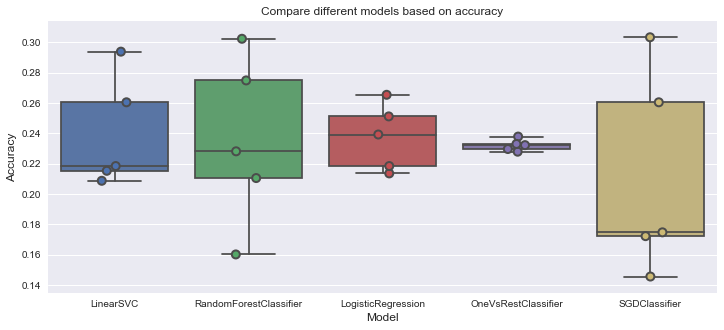

In [145]:
## Test several models and choose the one with the best accuracy
models = [
    LinearSVC(C= 0.1, loss= 'squared_hinge'),
    RandomForestClassifier(),    
    LogisticRegression(random_state=0),
    OneVsRestClassifier(MultinomialNB()),
    SGDClassifier(loss='hinge')
]

CV = 5 # 5-fold cross validation
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_tfidf, y_train, scoring='accuracy', cv=CV)
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
plt.figure(figsize=(12,5))
plt.title('Compare different models based on accuracy')
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.show()

In [146]:
cv_df.groupby('model_name').accuracy.mean().sort_values(ascending=False)

model_name
LinearSVC                 0.239360
LogisticRegression        0.237568
RandomForestClassifier    0.235217
OneVsRestClassifier       0.232135
SGDClassifier             0.211284
Name: accuracy, dtype: float64

** Define the model **

In [70]:
## LinearSVC is chosen as best model
def LinearSVCClass(X_train, y_train, X_test):
    classifier = LinearSVC(C= 0.1, loss= 'squared_hinge')

    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    
    return y_pred

** Helper function to plot confusion matrix **

In [71]:
## Plot the confusion matrix
def plotCM(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    scores = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=scores, yticklabels=scores)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()
    return cm

** Run the classifier **

Balanced accuracy:  0.26464427591188155
Accuracy:  0.3217821782178218
Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        55
           3       0.33      0.85      0.48       100
           4       0.08      0.02      0.03        54
           5       0.31      0.34      0.32        65
           6       0.34      0.33      0.33        67
           7       0.00      0.00      0.00        30
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00         1

   micro avg       0.32      0.32      0.32       404
   macro avg       0.11      0.15      0.12       404
weighted avg       0.20      0.32      0.23       404

Confusion matrix: 



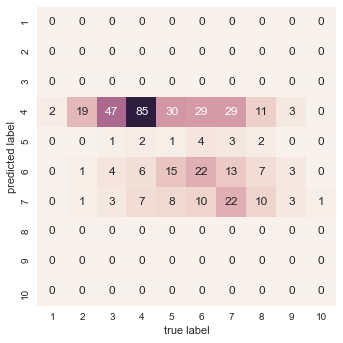

In [72]:
## SVM classification
y_pred = LinearSVCClass(X_train_tfidf, y_train, X_test_tfidf)

print('Balanced accuracy: ', balanced_accuracy_score(y_pred, y_test))
print('Accuracy: ', accuracy_score(y_pred, y_test))
print('Classification report: \n', classification_report(y_test, y_pred))
print('Confusion matrix: \n')
cm = plotCM(y_test, y_pred)

** Upsample dataset to balance the classes**

In [83]:
## We do upsampling now, to solve the issue of im-balanced data
## We have a very few data for scores 1, 2, 9 and 10. The classes 4 has lot of reviews, followed by 3, 5, 6, 7, 8.
## So, we try to balance the data, by upsampling all the classes to meet the number of samples that class 4 has.

main_df = train_df

# Separate the majority and the minority classes. 
# HINT: Here, the class 4 is 3 becaue the scale of score we work with is 0-9, 
# while in plots and other reporting metrics we use the scale 1-10
df_majority = main_df[main_df.score==3]
df_minority = main_df[main_df.score!=3]
print('majority: ', df_majority.shape)
print('minority: ', df_minority.shape)


df_minority_upsampled = []
for i,k in enumerate([0, 1, 2, 4, 5, 6, 7, 8, 9]):
    diff = (len(df_majority)-len(df_minority[df_minority.score==k]))
    print(diff)
    df_minority_upsampled.append(resample(df_minority[df_minority.score==k], replace=True, n_samples=diff)) 
    
df_minority_ups = pd.concat(df_minority_upsampled)
df_minority_merged = pd.concat([df_minority_ups, df_minority])
print('minority upsampled: ', df_minority_merged.shape)

main_df_upsampled = pd.concat([df_majority, df_minority_merged])
print('upsampled main df: ', main_df_upsampled.shape)
print('samples per score after upsampled:\n', main_df_upsampled.score.value_counts())

majority:  (242, 3)
minority:  (805, 3)
236
194
126
76
49
59
167
226
240
minority upsampled:  (2178, 3)
upsampled main df:  (2420, 3)
samples per score after upsampled:
 9    242
7    242
5    242
3    242
1    242
8    242
6    242
4    242
2    242
0    242
Name: score, dtype: int64


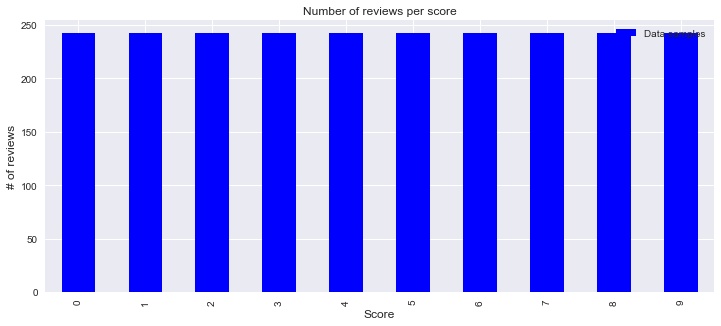

In [84]:
# check the distribution of upsampled dataset
df_stats = main_df_upsampled.score.value_counts()

plt.figure(figsize=(12,5))
plt.title('Number of reviews per score')
ax1 = df_stats.sort_index(ascending=True).plot(color='blue', grid=True, label='Data samples', kind='bar', legend=False)
ax1.legend(loc=1)
plt.ylabel('# of reviews', fontsize=12)
plt.xlabel('Score', fontsize=12)
plt.show()


In [85]:
# Let's now use the upsampled data as training data and use the very first test set as test data
# This test set has never been used
train_dataset = main_df_upsampled
test_dataset = test_df # test set split in the very beginning 

print('train', train_dataset.shape)
print('test', test_dataset.shape)

train (2420, 3)
test (404, 3)


In [86]:
print('train', train_dataset.score.unique())
print('test', test_dataset.score.unique())

train [3 0 1 2 4 5 6 7 8 9]
test [4 3 2 1 0 7 5 6 8 9]


In [87]:
# extract features
X_train_tfidf, X_test_tfidf = TFIDFvec(train_dataset.comments, test_dataset.comments)

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(2420, 115206)
(404, 115206)


Balanced accuracy:  0.3165842498943384
Accuracy:  0.30445544554455445
Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.26      0.62      0.37        21
           2       0.14      0.07      0.10        55
           3       0.47      0.42      0.44       100
           4       0.14      0.17      0.15        54
           5       0.33      0.42      0.37        65
           6       0.34      0.36      0.35        67
           7       0.17      0.10      0.12        30
           8       0.00      0.00      0.00         9
           9       1.00      1.00      1.00         1

   micro avg       0.30      0.30      0.30       404
   macro avg       0.28      0.32      0.29       404
weighted avg       0.29      0.30      0.29       404

Confusion matrix: 



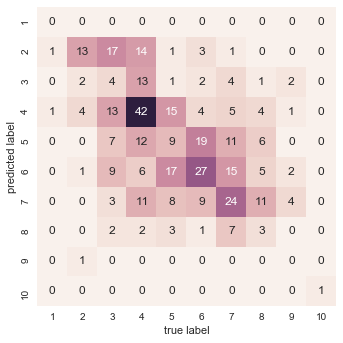

In [88]:
## LinearSVC classification trained on upsampled data and tested on the unseen test set (not upsampled)
y_pred = LinearSVCClass(X_train_tfidf, train_dataset.score, X_test_tfidf)

print('Balanced accuracy: ', balanced_accuracy_score(y_pred, y_test))
print('Accuracy: ', accuracy_score(y_pred, test_dataset.score))
print('Classification report: \n', classification_report(test_dataset.score, y_pred))
print('Confusion matrix: \n')
cm = plotCM(test_dataset.score, y_pred)

## Put in use the unlabeled data

** Generate labels for unlabeled data using the upsampled data as part of training data **

In [90]:
# use labeled train dataset as training
X_train = main_df_upsampled.comments
y_train = main_df_upsampled.score
X_test = unlabeled_df.comments

# extract features
X_train_tfidf, X_test_tfidf = TFIDFvec(X_train, X_test)

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(2420, 115206)
(8574, 115206)


In [91]:
# predict the labels for unlabeled data and attach labels to them
y_pred_svc = LinearSVCClass(X_train_tfidf, y_train, X_test_tfidf)

In [92]:
# use predicated labels from LinearSVC as test labels
y_test = y_pred_svc

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

# First merge corresponding training samples and targets (train and test)
df_train = pd.DataFrame(
    {'comments': X_train,
     'score': y_train
    })

df_test = pd.DataFrame(
    {'comments': X_test,
     'score': y_test
    })

# Now merge both train and test datasets to one dataset that will be used as training for final LinearSVC run
df_main_train = pd.concat([df_train, df_test], join="inner", ignore_index=True)

print('Main train dataset consists of first train split (stored in csv file) and unlabeled data that now are labeled:'
      , df_main_train.shape)

X_train:  (2420,)
y_train:  (2420,)
X_test:  (8574,)
y_test:  (8574,)
Main train dataset consists of first train split (stored in csv file) and unlabeled data that now are labeled: (10994, 2)


In [96]:
# Now for final round, we use df_main_train as training set and as test set we use the first split test I did 
# in the beginning and stored as CSV file
# The test set is never touched during these experiments, it is used only to test the classifier with upsampled
# data as training and this time when we test the classifier after we train it with unlabeled data as well but
# now having the labels

# There is not a good propotion split between train and test datasets this time, but walking through the experiments
# one can understand that we saved this test dataset in the beginning when we had very few data

final_X_train = df_main_train.comments
final_y_train = df_main_train.score
final_X_test = test_df.comments
final_y_test = test_df.score

print('final_X_train: ', final_X_train.shape)
print('final_y_train: ', final_y_train.shape)
print('final_X_test: ', final_X_test.shape)
print('final_y_test: ', final_y_test.shape)

final_X_train:  (10994,)
final_y_train:  (10994,)
final_X_test:  (404,)
final_y_test:  (404,)


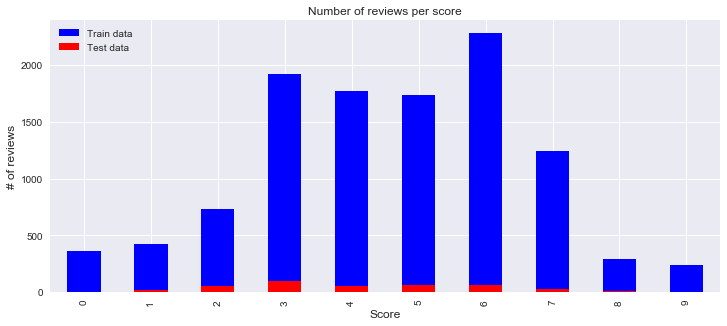

In [97]:
df_stats_train = final_y_train.value_counts()
df_stats_test = final_y_test.value_counts()

plt.figure(figsize=(12,5))
plt.title('Number of reviews per score')
ax1 = df_stats_train.sort_index(ascending=True).plot(color='blue', grid=True, label='Train data', kind='bar', legend=False)
ax2 = df_stats_test.sort_index(ascending=True).plot(color='red', grid=True, label='Test data', kind='bar', legend=False)
ax1.legend(loc=1)
ax2.legend(loc=2)
plt.ylabel('# of reviews', fontsize=12)
plt.xlabel('Score', fontsize=12)
plt.show()

In [98]:
# Now lets run LinearSVC on the full training dataset (labeled train_df and unlabeled data, that are merged) and 
# test the classifier with our famous test_df we split in the very beginning and never included in any of the 
# experiments with upsampling and label prediction for unlabeled but it just helped us for testing on these tasks

X_train_tfidf, X_test_tfidf = TFIDFvec(final_X_train, final_X_test)

print('Final train ', X_train_tfidf.shape)
print('Final test ', X_test_tfidf.shape)

Final train  (10994, 798000)
Final test  (404, 798000)


Balanced accuracy:  0.3272740019431196
Accuracy:  0.2871287128712871
Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.24      0.38      0.29        21
           2       0.07      0.02      0.03        55
           3       0.44      0.44      0.44       100
           4       0.18      0.24      0.20        54
           5       0.28      0.38      0.32        65
           6       0.29      0.33      0.31        67
           7       0.12      0.07      0.09        30
           8       0.00      0.00      0.00         9
           9       1.00      1.00      1.00         1

   micro avg       0.29      0.29      0.29       404
   macro avg       0.26      0.29      0.27       404
weighted avg       0.26      0.29      0.27       404

Confusion matrix: 



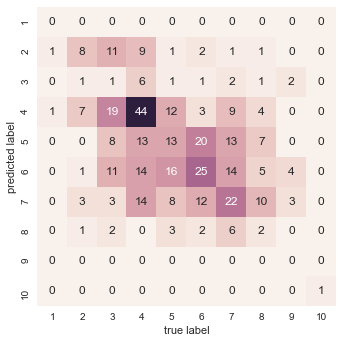

In [99]:
## LinearSVC classification
y_pred = LinearSVCClass(X_train_tfidf, final_y_train, X_test_tfidf)

print('Balanced accuracy: ', balanced_accuracy_score(y_pred, final_y_test))
print('Accuracy: ', accuracy_score(y_pred, final_y_test))
print('Classification report: \n', classification_report(final_y_test, y_pred))
print('Confusion matrix: \n')
cm = plotCM(final_y_test, y_pred)